In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from models_package import StudentModel, TeacherModel
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [2]:
def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    inputs, _ = next(iter(dataloader))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time

def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for inputs, labels in dataloader:
        with torch.no_grad():
            teacher_outputs = teacher(inputs.to(device))
            student_outputs = student(inputs.to(device))
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(torch.argmax(teacher_outputs, dim=1).cpu().numpy())
        all_student_preds.append(torch.argmax(student_outputs, dim=1).cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),  # Updated line
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return metrics

def plot_comparison(labels, teacher_values, student_values, title, ylabel):
    # Convert parameter count to millions
    if 'Parameter Count' in title or 'Parameter Count' in ylabel:
        teacher_values = [value / 1e6 for value in teacher_values]
        student_values = [value / 1e6 for value in student_values]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, teacher_values, width, label='Teacher')
    rects2 = ax.bar(x + width/2, student_values, width, label='Student')

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()

    plt.show()

In [3]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 2
num_workers = 2
batch_size = 32
temperature = 4.0
alpha = 0.9
momentum = 0.9
num_classes = 100
step_size = 30
gamma = 0.1

# Load the CIFAR-100 dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

trainset = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers
)


Files already downloaded and verified


In [4]:
# Instantiate the models
teacher_model = TeacherModel(in_features=64, num_classes=num_classes)
student_model = StudentModel(in_features=16, num_classes=num_classes)

# Optimizer and scheduler for the student model
optimizer = optim.SGD(student_model.parameters(), lr=learning_rate, momentum=momentum)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

criterion = nn.CrossEntropyLoss()

# Knowledge Distillation loss function
def knowledge_distillation_loss(student_outputs, teacher_outputs, temperature):
    kd_loss = F.kl_div(
        F.log_softmax(student_outputs / temperature, dim=1),
        F.softmax(teacher_outputs / temperature, dim=1),
        reduction='batchmean'
    ) * (temperature * temperature)
    return kd_loss

# Function to train the teacher model
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, num_epochs=5):
    model.train()
    model.to(device)
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 99:  # Print every 100 mini-batches
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0
        scheduler.step()
    print("Finished Training Teacher")

# Function to train the student model with knowledge distillation
def train_student_with_distillation(student, teacher, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs):
    student.train()
    teacher.eval()
    student.to(device)
    teacher.to(device)
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)
            ce_loss = criterion(student_outputs, labels)
            kd_loss = knowledge_distillation_loss(student_outputs, teacher_outputs, temperature)
            loss = alpha * kd_loss + (1 - alpha) * ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 99:
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0
        scheduler.step()
    print("Finished Training Student")

# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Call the function to train the teacher model
train_teacher(teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=num_epochs)

# Call the function to train the student model with knowledge distillation
train_student_with_distillation(student_model, teacher_model, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs=num_epochs)

# Save the student model weights and architecture
torch.save(student_model.state_dict(), 'student_model_weights.pth')
torch.save(student_model, 'student_model.pth')
print('weights and architecture saved and exported')

  8%|█████████▉                                                                                                                      | 121/1563 [00:01<00:11, 125.24it/s]

[1, 100] loss: 4.521


 14%|█████████████████▊                                                                                                              | 217/1563 [00:02<00:10, 128.45it/s]

[1, 200] loss: 4.211


 20%|█████████████████████████▋                                                                                                      | 314/1563 [00:02<00:09, 132.72it/s]

[1, 300] loss: 4.081


 26%|█████████████████████████████████▉                                                                                              | 414/1563 [00:03<00:08, 134.88it/s]

[1, 400] loss: 3.967


 34%|███████████████████████████████████████████                                                                                     | 526/1563 [00:04<00:07, 132.66it/s]

[1, 500] loss: 3.939


 40%|███████████████████████████████████████████████████                                                                             | 624/1563 [00:05<00:07, 126.48it/s]

[1, 600] loss: 3.892


 46%|███████████████████████████████████████████████████████████▍                                                                    | 726/1563 [00:05<00:06, 132.26it/s]

[1, 700] loss: 3.851


 53%|███████████████████████████████████████████████████████████████████▌                                                            | 825/1563 [00:06<00:05, 134.19it/s]

[1, 800] loss: 3.803


 59%|███████████████████████████████████████████████████████████████████████████▊                                                    | 926/1563 [00:07<00:04, 137.04it/s]

[1, 900] loss: 3.799


 66%|███████████████████████████████████████████████████████████████████████████████████▏                                           | 1024/1563 [00:08<00:04, 124.95it/s]

[1, 1000] loss: 3.704


 72%|███████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1123/1563 [00:08<00:03, 130.10it/s]

[1, 1100] loss: 3.737


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 1220/1563 [00:09<00:02, 131.70it/s]

[1, 1200] loss: 3.711


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1321/1563 [00:10<00:01, 126.68it/s]

[1, 1300] loss: 3.656


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1418/1563 [00:11<00:01, 131.60it/s]

[1, 1400] loss: 3.651


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1515/1563 [00:11<00:00, 131.19it/s]

[1, 1500] loss: 3.596


  7%|█████████▍                                                                                                                      | 115/1563 [00:00<00:12, 116.59it/s]

[2, 100] loss: 3.583


 14%|█████████████████▌                                                                                                              | 215/1563 [00:01<00:10, 133.80it/s]

[2, 200] loss: 3.598


 20%|█████████████████████████▉                                                                                                      | 316/1563 [00:02<00:08, 138.92it/s]

[2, 300] loss: 3.515


 27%|█████████████████████████████████▉                                                                                              | 415/1563 [00:03<00:09, 126.70it/s]

[2, 400] loss: 3.524


 33%|██████████████████████████████████████████                                                                                      | 514/1563 [00:03<00:07, 135.68it/s]

[2, 500] loss: 3.478


 40%|██████████████████████████████████████████████████▊                                                                             | 620/1563 [00:04<00:07, 124.98it/s]

[2, 600] loss: 3.481


 46%|██████████████████████████████████████████████████████████▌                                                                     | 715/1563 [00:05<00:06, 125.72it/s]

[2, 700] loss: 3.466


 52%|██████████████████████████████████████████████████████████████████▋                                                             | 814/1563 [00:06<00:05, 128.35it/s]

[2, 800] loss: 3.451


 59%|███████████████████████████████████████████████████████████████████████████▌                                                    | 923/1563 [00:07<00:05, 124.50it/s]

[2, 900] loss: 3.455


 65%|██████████████████████████████████████████████████████████████████████████████████▋                                            | 1017/1563 [00:07<00:04, 126.84it/s]

[2, 1000] loss: 3.443


 71%|██████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1114/1563 [00:08<00:03, 130.14it/s]

[2, 1100] loss: 3.387


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 1223/1563 [00:09<00:02, 124.55it/s]

[2, 1200] loss: 3.400


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1319/1563 [00:10<00:01, 127.22it/s]

[2, 1300] loss: 3.400


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1414/1563 [00:11<00:01, 122.64it/s]

[2, 1400] loss: 3.374


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1513/1563 [00:11<00:00, 118.87it/s]

[2, 1500] loss: 3.402


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:12<00:00, 126.71it/s]


Finished Training Teacher


  8%|█████████▊                                                                                                                      | 120/1563 [00:01<00:12, 114.58it/s]

[1, 100] loss: 1.824


 14%|█████████████████▌                                                                                                              | 214/1563 [00:01<00:10, 128.98it/s]

[1, 200] loss: 1.450


 21%|██████████████████████████▎                                                                                                     | 322/1563 [00:02<00:09, 124.11it/s]

[1, 300] loss: 1.179


 27%|█████████████████████████████████▉                                                                                              | 415/1563 [00:03<00:08, 128.38it/s]

[1, 400] loss: 1.040


 33%|██████████████████████████████████████████                                                                                      | 514/1563 [00:04<00:08, 130.08it/s]

[1, 500] loss: 0.970


 40%|██████████████████████████████████████████████████▊                                                                             | 621/1563 [00:05<00:07, 122.31it/s]

[1, 600] loss: 0.894


 46%|██████████████████████████████████████████████████████████▋                                                                     | 717/1563 [00:05<00:06, 124.36it/s]

[1, 700] loss: 0.820


 52%|██████████████████████████████████████████████████████████████████▌                                                             | 813/1563 [00:06<00:05, 131.55it/s]

[1, 800] loss: 0.777


 58%|██████████████████████████████████████████████████████████████████████████▊                                                     | 913/1563 [00:07<00:05, 126.16it/s]

[1, 900] loss: 0.728


 65%|██████████████████████████████████████████████████████████████████████████████████▉                                            | 1020/1563 [00:08<00:04, 122.77it/s]

[1, 1000] loss: 0.711


 71%|██████████████████████████████████████████████████████████████████████████████████████████▋                                    | 1116/1563 [00:09<00:03, 123.07it/s]

[1, 1100] loss: 0.672


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 1213/1563 [00:09<00:02, 130.44it/s]

[1, 1200] loss: 0.659


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1326/1563 [00:10<00:01, 131.24it/s]

[1, 1300] loss: 0.643


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1424/1563 [00:11<00:01, 129.92it/s]

[1, 1400] loss: 0.634


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1520/1563 [00:12<00:00, 127.53it/s]

[1, 1500] loss: 0.600


  7%|█████████▌                                                                                                                      | 117/1563 [00:00<00:11, 127.68it/s]

[2, 100] loss: 0.581


 14%|█████████████████▌                                                                                                              | 215/1563 [00:01<00:10, 132.21it/s]

[2, 200] loss: 0.573


 20%|█████████████████████████▊                                                                                                      | 315/1563 [00:02<00:09, 131.98it/s]

[2, 300] loss: 0.559


 26%|█████████████████████████████████▊                                                                                              | 413/1563 [00:03<00:08, 130.63it/s]

[2, 400] loss: 0.548


 33%|█████████████████████████████████████████▉                                                                                      | 512/1563 [00:03<00:08, 129.73it/s]

[2, 500] loss: 0.535


 39%|██████████████████████████████████████████████████▌                                                                             | 617/1563 [00:04<00:07, 123.77it/s]

[2, 600] loss: 0.526


 46%|██████████████████████████████████████████████████████████▍                                                                     | 713/1563 [00:05<00:06, 131.94it/s]

[2, 700] loss: 0.514


 52%|███████████████████████████████████████████████████████████████████▏                                                            | 820/1563 [00:06<00:05, 124.30it/s]

[2, 800] loss: 0.505


 59%|██████████████████████████████████████████████████████████████████████████▉                                                     | 915/1563 [00:07<00:05, 124.14it/s]

[2, 900] loss: 0.500


 65%|███████████████████████████████████████████████████████████████████████████████████                                            | 1022/1563 [00:08<00:04, 122.34it/s]

[2, 1000] loss: 0.489


 71%|██████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1117/1563 [00:08<00:03, 129.70it/s]

[2, 1100] loss: 0.484


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 1214/1563 [00:09<00:02, 127.35it/s]

[2, 1200] loss: 0.478


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1324/1563 [00:10<00:01, 131.44it/s]

[2, 1300] loss: 0.469


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1422/1563 [00:11<00:01, 131.61it/s]

[2, 1400] loss: 0.461


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1519/1563 [00:11<00:00, 131.13it/s]

[2, 1500] loss: 0.454


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:12<00:00, 126.82it/s]

Finished Training Student
weights and architecture saved and exported


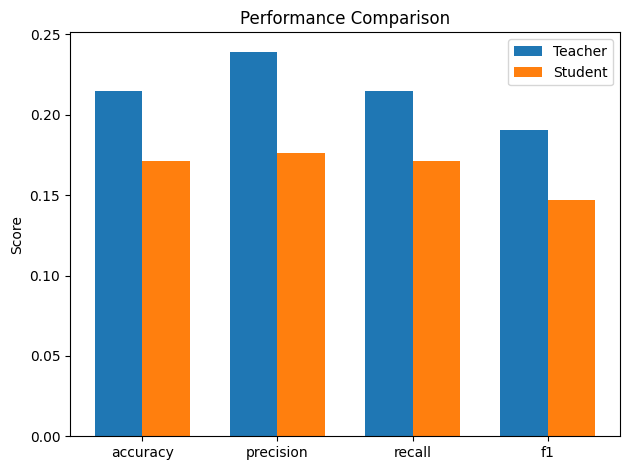

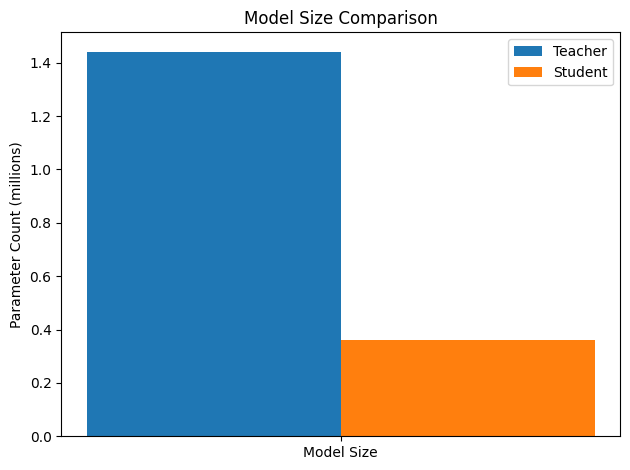

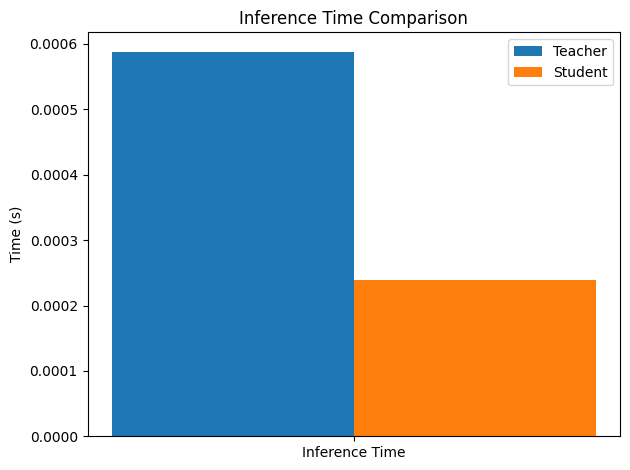

In [5]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, trainloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, trainloader)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]
student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')